### Download the package
```pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"```

In [7]:
import math
import os
import random

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import Trainer, TrainingArguments
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.time_series_preprocessor import DEFAULT_FREQUENCY_MAPPING

### Load data

In [8]:
from src.data.diabetes_datasets.kaggle_bris_t1d.bris_t1d import BrisT1DDataLoader

loader = BrisT1DDataLoader(use_cached=True)

INFO:p-45736:t-21496:bris_t1d.py:load_data:============================================================
INFO:p-45736:t-21496:bris_t1d.py:load_data:Beginning data loading process with the following parmeters:
INFO:p-45736:t-21496:bris_t1d.py:load_data:	Dataset: kaggle_brisT1D - train
INFO:p-45736:t-21496:bris_t1d.py:load_data:	Columns: None
INFO:p-45736:t-21496:bris_t1d.py:load_data:	Generic patient start date: 2024-01-01 00:00:00
INFO:p-45736:t-21496:bris_t1d.py:load_data:	Number of validation days: 20
INFO:p-45736:t-21496:bris_t1d.py:load_data:	In parallel with up to 3 workers.

INFO:p-45736:t-21496:cache_manager.py:get_processed_data_path:Processed data path for kaggle_brisT1D: c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\cache\data\kaggle_brisT1D\processed
INFO:p-45736:t-21496:bris_t1d.py:load_data:Loaded full processed data from cache for 9 patients
INFO:p-45736:t-21496:cache_manager.py:get_processed_data_path:Processed data path for kaggle_brisT1D: c:\Users\Tony\Glucos

### Training Arguments configuration

In [ ]:
# Try out r1 too
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# 100 for full-shot
FEWSHOT_PERCENT = 100
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96

# Which resolution to train on (15 or 5)
RESOLUTION_MIN = 5

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
interval = f"{RESOLUTION_MIN}mins"

# Where to save the checkpoint
OUT_DIR = f"../../models/ttm/kaggle_brisT1D/{interval}/{current_time}"

### Data processing for ttm

In [10]:
from src.tuning.benchmark import impute_missing_values

y_feature = ["bg_mM"]
## add categorical features (ttm does support it)
x_features = ["steps", "cob", "carb_availability", "insulin_availability", "iob"]

# datetime is the index column...
timestamp_column = "datetime"

# exogenous features
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": ["id"],
    "target_columns": y_feature,
    "control_columns": x_features,
}

data_dict = loader.processed_data


def reduce_features_multi_patient(patients_dict, interval=RESOLUTION_MIN):
    """
    Process each patient's data separately to avoid datetime index issues
    """
    processed_patients = []

    for patient_id, df in patients_dict.items():
        # Check if patient has the correct interval
        if (df.index[1] - df.index[0]).components.minutes == interval:
            print(f"Processing patient {patient_id}...")
            # Process each patient individually
            p_df = df.iloc[:]
            p_df = p_df[x_features + y_feature]
            # Impute missing values for this patient
            p_df = impute_missing_values(p_df, columns=x_features)
            p_df = impute_missing_values(p_df, columns=y_feature)
            p_df["id"] = patient_id
            processed_patients.append(p_df)

    return pd.concat(processed_patients)


# Use this instead of combining all patients first
all_patients_df = reduce_features_multi_patient(data_dict)

# datetime has to be a column
data = all_patients_df.reset_index()

# Train/val/test split
data_length = len(data)
split_config = {
    "train": 0.7,  # 70% for training
    "test": 0.2,  # 20% for testing (10% auto-assigned to validation)
}
print(data["id"].unique())

Processing patient p02...
Processing patient p03...
Processing patient p04...
Processing patient p10...
Processing patient p11...
Processing patient p12...
['p02' 'p03' 'p04' 'p10' 'p11' 'p12']


In [22]:
data.columns

Index(['datetime', 'steps', 'cob', 'carb_availability', 'insulin_availability',
       'iob', 'bg_mM', 'id'],
      dtype='object')

## Few-shot / Full-shot settings

In [123]:
def get_finetune_trainer(
    dataset_name,
    model_path,
    batch_size,
    learning_rate=None,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",  # TODO:TONY - Try out Pinball loss too
    quantile=0.5,
    use_cpu=False,
    # training_args=None,
):
    if num_epochs is None:
        raise ValueError("num_epochs must be provided")

    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    finetune_forecast_model = get_model(
        model_path,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=DEFAULT_FREQUENCY_MAPPING[f"{RESOLUTION_MIN}min"],
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        loss=loss,
        quantile=quantile,
    )

    # TODO:TONY - Pull this out of the function and check the shape of the data
    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="last",  # Take the last x percent of the training data
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=100,
        logging_dir=os.path.join(
            out_dir, "logs"
        ),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        use_cpu=use_cpu,
    )

    # Create the early stopping callback
    # early_stopping_callback = EarlyStoppingCallback(
    #     early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    #     early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    # )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[
            # TODO:TONY - Remove early stopping for now
            # early_stopping_callback,
            tracking_callback
        ],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    return finetune_forecast_trainer, dset_test

In [124]:
# From the doc string, I think this is the percentage of the training data to use for few shot finetuning
dataset_name = f"{RESOLUTION_MIN}min_patients"
finetune_forecast_trainer, dset_test = get_finetune_trainer(
    model_path=TTM_MODEL_PATH,
    dataset_name=dataset_name,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=FEWSHOT_PERCENT,
    learning_rate=0.001,
    save_dir=OUT_DIR,
)

INFO:p-45736:t-21496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-45736:t-21496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.


-------------------- Running few-shot 100% --------------------


INFO:p-45736:t-21496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


### Training: Start the finetune

In [24]:
### Fine-tune
finetune_forecast_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.859600,0.887566
2,0.837900,0.880542
3,0.829500,0.877568
4,0.823500,0.875270
5,0.819300,0.874932
6,0.817100,0.877646
7,0.815900,0.873833
8,0.814800,0.877452
9,0.814400,0.877952
10,0.814100,0.874753


[TrackingCallback] Mean Epoch Time = 51.38994572639465 seconds, Total Train Time = 4280.190139293671


TrainOutput(global_step=82250, training_loss=0.7874508616902546, metrics={'train_runtime': 4280.1901, 'train_samples_per_second': 1229.501, 'train_steps_per_second': 19.216, 'total_flos': 7.8110871552e+16, 'train_loss': 0.7874508616902546, 'epoch': 50.0})

### Training: Evaluate

In [25]:
# Evaluation
print("+" * 20, f"Test MSE after few-shot {FEWSHOT_PERCENT}% fine-tuning", "+" * 20)
finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
print(fewshot_output)
print("+" * 60)

++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.9558927416801453, 'eval_runtime': 35.2019, 'eval_samples_per_second': 867.539, 'eval_steps_per_second': 13.579, 'epoch': 50.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Training: Predict

In [ ]:
# get predictions
finetune_forecast_trainer.args.per_device_eval_batch_size = 16
predictions_dict = finetune_forecast_trainer.predict(dset_test)
predictions_np = predictions_dict.predictions[0]
print(predictions_np.shape)

# get backbone embeddings (if needed for further analysis)
backbone_embedding = predictions_dict.predictions[1]
print(backbone_embedding.shape)

### Training: Plot
- It is possible this will run out of memory 

In [ ]:
# plot
prediction_to_plot = 10

# random.seed(42)  # For reproducibility
test_dataset_size = len(dset_test)
valid_indices = random.sample(
    range(test_dataset_size), min(prediction_to_plot, test_dataset_size)
)
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_fewshot",
    indices=valid_indices,
    channel=0,
)

### Training: Eval_loss vs epochs

Total epochs: 50
Epoch range: 1.0 to 50.0
Loss range: 0.8738 to 0.8876
Final loss: 0.8789


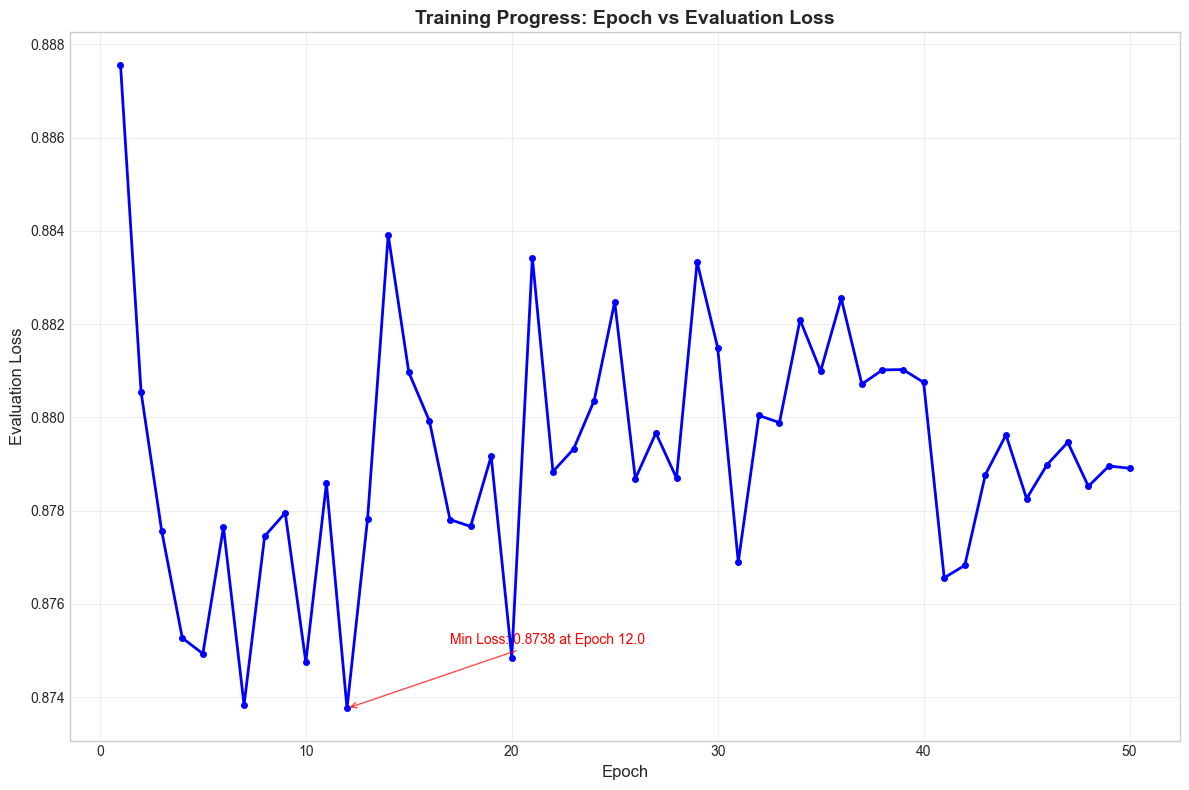

In [82]:
import os
import json
import matplotlib.pyplot as plt

latest_checkpoint = "../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output/checkpoint-82250"

trainer_state = json.load(open(os.path.join(latest_checkpoint, "trainer_state.json")))
log_history = trainer_state["log_history"]
epochs = []
eval_losses = []

for entry in log_history:
    if "epoch" in entry and "eval_loss" in entry:
        epochs.append(entry["epoch"])
        eval_losses.append(entry["eval_loss"])

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, eval_losses, "b-", linewidth=2, marker="o", markersize=4)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Evaluation Loss", fontsize=12)
plt.title("Training Progress: Epoch vs Evaluation Loss", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add some statistics
min_loss = min(eval_losses)
min_epoch = epochs[eval_losses.index(min_loss)]
plt.annotate(
    f"Min Loss: {min_loss:.4f} at Epoch {min_epoch}",
    xy=(min_epoch, min_loss),
    xytext=(
        min_epoch + len(epochs) * 0.1,
        min_loss + (max(eval_losses) - min(eval_losses)) * 0.1,
    ),
    arrowprops=dict(arrowstyle="->", color="red", alpha=0.7),
    fontsize=10,
    color="red",
)

print(f"Total epochs: {len(epochs)}")
print(f"Epoch range: {min(epochs)} to {max(epochs)}")
print(f"Loss range: {min(eval_losses):.4f} to {max(eval_losses):.4f}")
print(f"Final loss: {eval_losses[-1]:.4f}")

plt.show()

### Load from a checkpoint
- Might need to restart the kernel to clear the GPU cache or it will run out of memory
- It is so bad that even torch.cuda.empty_cache() doesn't work

INFO:p-45736:t-21496:get_model.py:get_model:Loading model from: ../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output/checkpoint-19740
INFO:p-45736:t-21496:get_model.py:get_model:Model loaded successfully from ../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output/checkpoint-19740, revision = None.
INFO:p-45736:t-21496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


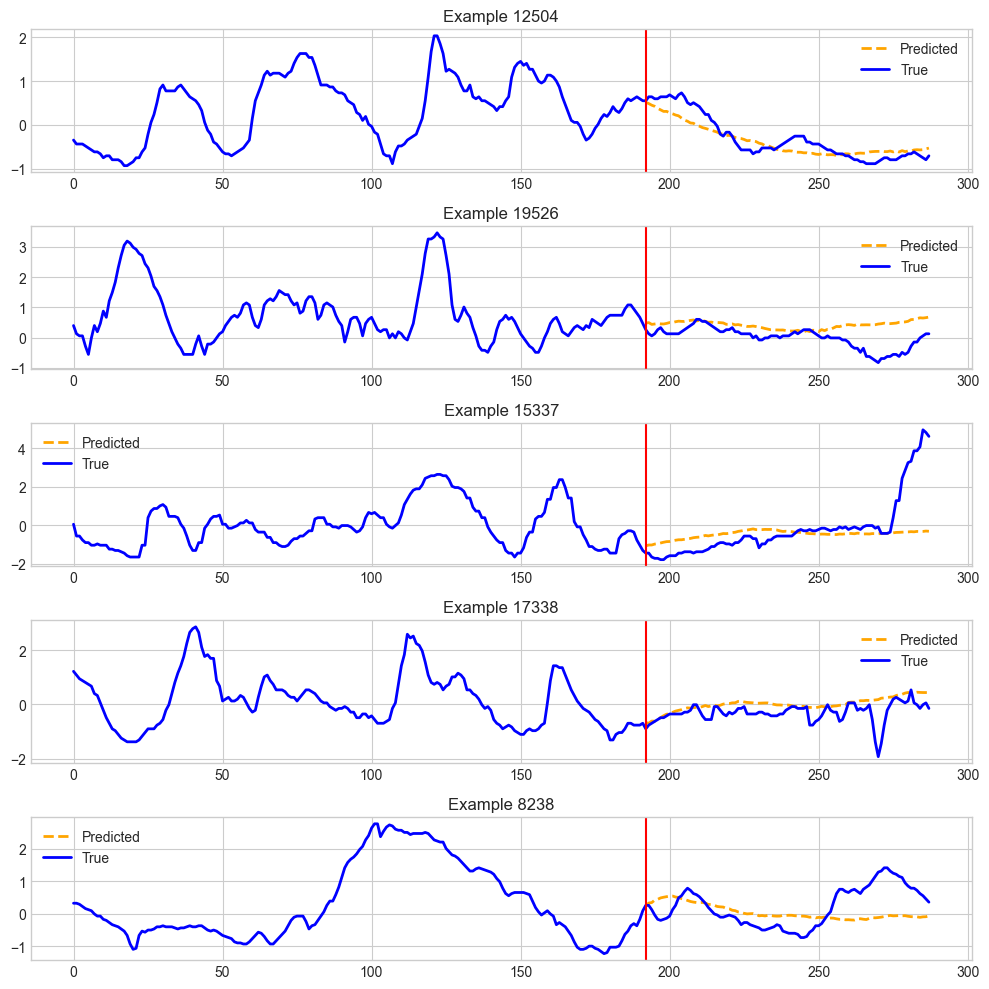

In [48]:
saved_path = "../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output/checkpoint-19740"

saved_model = get_model(
    saved_path,  # Direct checkpoint path
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
)

num_predictions = 5
test_dataset_size = len(dset_test)
valid_indices = random.sample(
    range(test_dataset_size), min(num_predictions, test_dataset_size)
)
plot_predictions(
    model=saved_model,
    dset=dset_test,
    id_columns=["id"],
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_fewshot",
    indices=valid_indices,
    channel=0,
)

In [ ]:
# Find the latest checkpoint in the saved directory
import glob
import os
import torch
from pprint import pprint

### Continue training from a checkpoint
# This should be the OUT_DIR from the previous training run
saved_dir = (
    "../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output"
)
continue_trainer_tuple = None

## This will be the number of epochs we want to train for
NUM_EPOCHS_TO_TRAIN = 70

checkpoint_dirs = glob.glob(os.path.join(saved_dir, "checkpoint-*"))
if checkpoint_dirs:
    # Sort by checkpoint number to get the latest one
    latest_checkpoint = max(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))
    print(f"Latest checkpoint found: {latest_checkpoint}")

    training_args = torch.load(os.path.join(latest_checkpoint, "training_args.bin"))
    training_args_dict = training_args.to_dict()
    pprint(training_args_dict)

    # dataset_name = f"{RESOLUTION_MIN}min_patients"
    continue_trainer_tuple = get_finetune_trainer(
        model_path=latest_checkpoint,
        dataset_name="5min_patients",
        batch_size=training_args_dict["per_device_train_batch_size"],
        context_length=CONTEXT_LENGTH,
        forecast_length=PREDICTION_LENGTH,
        num_epochs=NUM_EPOCHS_TO_TRAIN,
        # training_args=training_args_dict
    )

    print(f"Model loaded from latest checkpoint: {os.path.basename(latest_checkpoint)}")
else:
    print("No checkpoints found in the specified directory")
    latest_model = None

C:\Users\Tony\AppData\Local\Temp\ipykernel_45736\455878189.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_args = torch.load(os.path.join(latest_checkpoint, "t

Latest checkpoint found: ../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_12-12-36/5min_patients/output\checkpoint-82250
{'accelerator_config': {'dispatch_batches': None,
                        'even_batches': True,
                        'gradient_accumulation_kwargs': None,
                        'non_blocking': False,
                        'split_batches': False,
                        'use_seedable_sampler': True},
 'adafactor': False,
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_epsilon': 1e-08,
 'auto_find_batch_size': False,
 'average_tokens_across_devices': False,
 'batch_eval_metrics': False,
 'bf16': False,
 'bf16_full_eval': False,
 'data_seed': None,
 'dataloader_drop_last': False,
 'dataloader_num_workers': 8,
 'dataloader_persistent_workers': False,
 'dataloader_pin_memory': True,
 'dataloader_prefetch_factor': None,
 'ddp_backend': None,
 'ddp_broadcast_buffers': None,
 'ddp_bucket_cap_mb': None,
 'ddp_find_unused_parameters': None,
 'ddp_timeout': 1800,
 'debu

c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\tsfm_public\toolkit\lr_finder.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

OPTIMAL SUGGESTED LEARNING RATE = 0.0015922827933410938
Using learning rate = 0.0015922827933410938
Model loaded from latest checkpoint: checkpoint-82250


In [133]:
continue_trainer, dset_test = continue_trainer_tuple
continue_trainer.train(resume_from_checkpoint=True)

ValueError: No valid checkpoint found in output directory (../../models/ttm/kaggle_brisT1D/5mins/2025-09-28_13-53-48\5min_patients\output)